In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_PATH = Path('../data/cleaned')

fact_events = DATA_PATH / 'fact_events_cleaned.parquet'
fact_products = DATA_PATH / 'fact_product_cleaned.parquet'

df_events = pd.read_parquet(fact_events)
df_products = pd.read_parquet(fact_products)

In [257]:
df_events.info()
sns.set_style('ticks')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251084 entries, 0 to 2251083
Data columns (total 17 columns):
 #   Column                Dtype              
---  ------                -----              
 0   user_id               object             
 1   event_name            category           
 2   transaction_id        object             
 3   event_date            datetime64[ns]     
 4   event_ts              datetime64[us, UTC]
 5   engagement_time_msec  Int64              
 6   session_id            Int64              
 7   device                category           
 8   country               category           
 9   region                object             
 10  city                  object             
 11  traffic_sname         object             
 12  traffic_smedium       object             
 13  traffic_source        object             
 14  marketing_channel     category           
 15  is_purchase           bool               
 16  is_engaged_event      boolean       

---
## 1️⃣Where do users drop off in the funnel?
---

In [155]:
funnel = [
    'view_item'    
    ,'add_to_cart'   
    ,'begin_checkout'   
    ,'add_shipping_info'   
    ,'add_payment_info'   
    ,'purchase'   
]

funnel_events = (
    df_events[df_events['event_name'].isin(funnel)]
    .groupby('event_name',observed=True)['user_id']
    .nunique()
    .reindex(funnel)
    .reset_index()
)  

funnel_events.columns = ['stage', 'user_count']


funnel_events['drop_off_pct'] = (
    1 - (funnel_events['user_count'] / funnel_events['user_count'].shift(1))
)
funnel_events

,stage,user_count,drop_off_pct
0,view_item,61252,NaN
1,add_to_cart,12545,0.795190
2,begin_checkout,9715,0.225588
3,add_shipping_info,9714,0.000103
4,add_payment_info,5751,0.407968
5,purchase,4419,0.231612


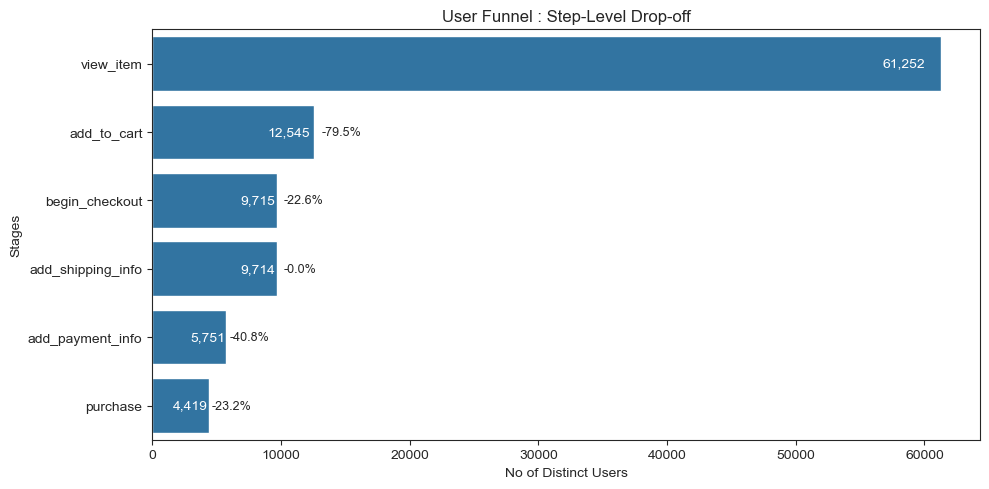

In [159]:
plt.figure(figsize = (10,5))
sns.barplot(
    data=funnel_events,
    y='stage',
    x='user_count',
)

for i, row in funnel_events.iterrows():
    plt.text(
        row['user_count'] * .98,
        i,
        f"{row['user_count']:,}",
        va = 'center',
        ha = 'right',
        color = 'white'
    )
    if row['drop_off_pct'] > 0:
        plt.text(
            row['user_count'] * 1.05,
            i,
            f"-{row['drop_off_pct']:.1%}",
            va = 'center',
            fontsize = 9
        )
plt.title('User Funnel : Step-Level Drop-off')
plt.ylabel('Stages')
plt.xlabel('No of Distinct Users')
plt.tight_layout()
plt.show()

## 2️⃣ Product decision vs checkout failure

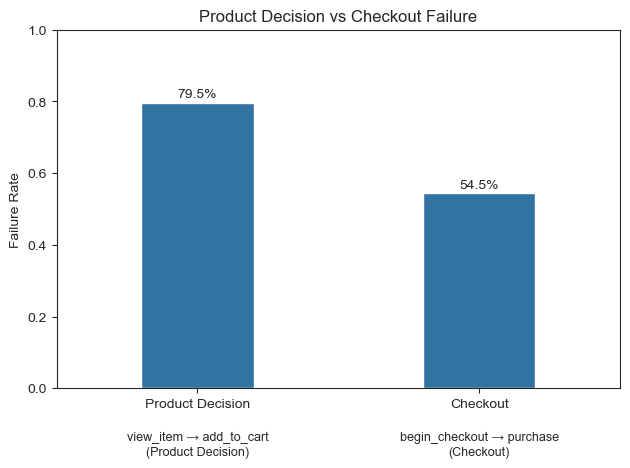

In [ ]:
friction = funnel_events.copy()
s = friction.set_index('stage')['user_count']
decision_failure = 1 - s['add_to_cart'] / s['view_item']
checkout_failure = 1 - s['purchase'] / s['begin_checkout']

failure = pd.DataFrame({
    'failure_stage': ['Product Decision','Checkout'],
    'failure_rate': [decision_failure,checkout_failure]
})

sns.barplot(
    data =failure,
    x= 'failure_stage',
    y= 'failure_rate',
    width = .4
)

plt.title('Product Decision vs Checkout Failure')
plt.ylabel('Failure Rate')
plt.xlabel('')
plt.ylim(0,1)


for i, row in failure.iterrows():
    plt.text(
        i,                         # x-position = category index
        row['failure_rate'] * 1.01,       # y-position = bar height
        f"{row['failure_rate']:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.text(
    0,
    -0.12,
    'view_item → add_to_cart\n(Product Decision)',
    ha='center',
    va='top',
    fontsize=9
)

plt.text(
    1,
    -0.12,
    'begin_checkout → purchase\n(Checkout)',
    ha='center',
    va='top',
    fontsize=9
)

plt.tight_layout()
plt.show()



## 3️⃣ Purchase intent vs browsing

In [223]:
intent_events = [
    'view_item',
    'add_to_cart',
    'begin_checkout',
    'purchase'
]

user_intents = df_events[df_events['event_name'].isin(intent_events)].copy()
user_intents = (user_intents.groupby(['user_id','event_name'], observed = True)
                .size()
                .unstack(fill_value=0)
                .reset_index()
                
)

def classify_intent(row):
    if row.get('purchase',0) > 0:
        return 'Converted'
    elif row.get('add_to_cart',0) > 0 or row.get('begin_checkout',0) > 0:
        return 'High Intent'
    else:
        return 'Browsing'

user_intents['intent_type'] = user_intents.apply(classify_intent, axis = 1)

user_intents

event_name,user_id,add_to_cart,begin_checkout,purchase,view_item,intent_type
0,10005335.8064658740,0,0,0,3,Browsing
1,1000631.1195930056,0,1,0,3,High Intent
2,1000684.0967461454,5,4,0,6,High Intent
3,10007546.3519345336,0,0,0,5,Browsing
4,10007643.0797593935,0,0,0,1,Browsing
...,...,...,...,...,...,...
61330,9994022576.9014163905,0,0,0,1,Browsing
61331,99957421.2543156267,0,0,0,40,Browsing
61332,99958657.3697881645,0,0,0,1,Browsing
61333,99966650.1405389057,2,0,0,2,High Intent


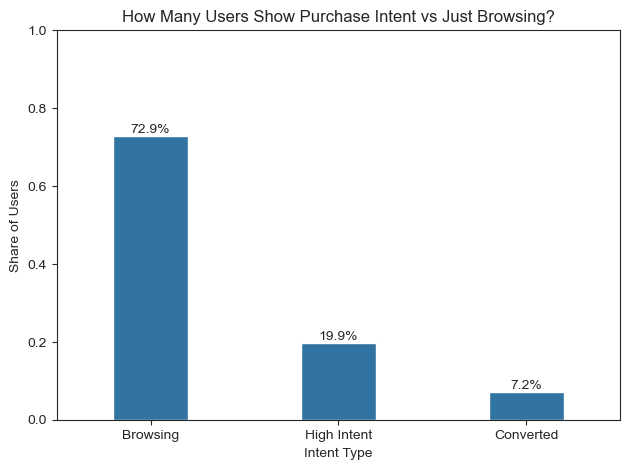

In [260]:
intent_summary = (
    user_intents['intent_type']
    .value_counts()
    .reset_index()
)

intent_summary.columns = ['intent_type', 'users']
intent_summary['share'] = intent_summary['users'] / intent_summary['users'].sum()

sns.barplot(
    data = intent_summary,
    x= 'intent_type',
    y = 'share',
    width = .4
)

for i, row in intent_summary.iterrows():
    plt.text(
        i,
        row['share'],
        f"{row['share']:.1%}",
        va= 'bottom',
        ha= 'center'
    )
plt.ylim(0,1)
plt.title("How Many Users Show Purchase Intent vs Just Browsing?")
plt.xlabel('Intent Type')
plt.ylabel('Share of Users')
plt.tight_layout()
plt.show()

## 4️⃣ High-intent traffic sources 

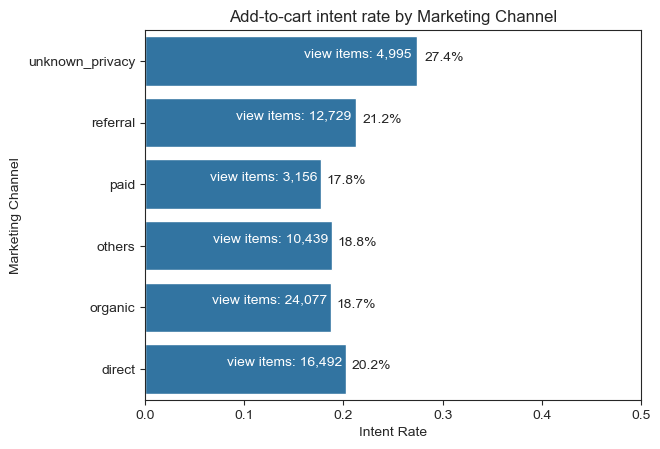

In [314]:
channel_intent = df_events[df_events['event_name'].isin(['view_item','add_to_cart'])].copy()
channel_intent = (
    channel_intent.groupby(['marketing_channel','event_name'] ,observed = True)['user_id']
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)
channel_intent['intent_rate'] = channel_intent['add_to_cart'] / channel_intent['view_item']
channel_intent

sns.barplot(
    data=channel_intent,
    y='marketing_channel',
    x='intent_rate',
)
for i ,row in channel_intent.iterrows():
    plt.text(
        row['intent_rate'] * .98,
        i,
        f"view items: {row['view_item']:,}",
        va= 'bottom',
        ha = 'right',
        color = 'white'   
    )
    plt.text(
        row['intent_rate']* 1.03,
        i,
        f"{row['intent_rate']:.1%}",
        ha='left'
    )
plt.xlim(0,.5)
plt.title('Add-to-cart intent rate by Marketing Channel')
plt.ylabel('Marketing Channel')
plt.xlabel('Intent Rate')
plt.gca().invert_yaxis()
plt.show()
